## <font color='Blue'>Introduction</font>
###  In the practical, we run the example model for evaluation of permebaility field.

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](./darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](./darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [Deadoil](./darts/models/physics/dead_oil_python.py) for basic dead oil physics
 * Class [Deadoil-properties](./darts/models/physics/do_properties_python.py) for dead oil properties, such as density, viscosity and relative permeability
2. Use run_python procedure to control run from the python script
3. Introduce wells and time-dependent well controls
4. Redefine physical properties and run simulation with custom-defined property.

## <font color='Blue'>Let's start!</font>


In [1]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.dead_oil_python import DeadOil
from darts.models.darts_model import DartsModel
from darts.engines import value_vector
from darts.tools.keyword_file_tools import load_single_keyword

import numpy as np
import matplotlib.pyplot as plt

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [2]:
class Model(DartsModel):
    def __init__(self, perm=None, nd = 51, db = 8):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.ix = np.int32((1/2)*self.nx)
        self.iy = np.int32((1/2)*self.ny)
        
        self.x = np.int32(self.nx )
        self.y = np.int32(self.ny )
        
        self.xx = np.int32(self.nx /self.nx)
        self.yy = np.int32(self.ny /self.ny )
        
        self.xxx = np.int32(self.nx /self.nx)
        self.yyy = np.int32(self.ny)
        
        self.xxxx = np.int32(self.nx)
        self.yyyy = np.int32(self.ny/self.ny)
        
        
        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=10)

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.x, self.y, 1, well_index=10)
        
        self.reservoir.add_well("PRD2")
        self.reservoir.add_perforation(self.reservoir.wells[-1],self.xx ,self.yy, 1, well_index=10)
        
        self.reservoir.add_well("PRD3")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.xxx, self.yyy, 1, well_index=10)
        
        self.reservoir.add_well("PRD4")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.xxxx, self.yyyy, 1, well_index=10)
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

<img style="float: left;" src="slides/Slide7.JPG" width="80%">

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
simulation ended


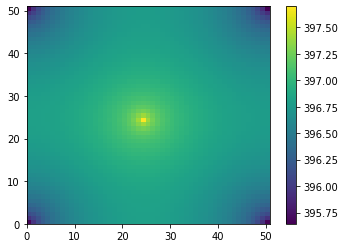

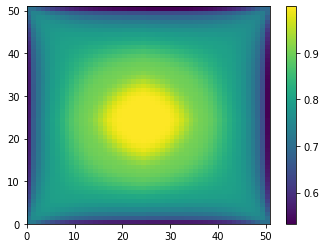

In [3]:
m=Model()
m.init()
m.run(2000)
print('simulation ended')

X = np.array(m.physics.engine.X, copy=False)
nb = m.nx * m.ny

p= X[0:2*nb:2]
z= X[1:2*nb:2]

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
plt.pcolor(p.reshape(m.ny, m.nx))
plt.colorbar()

plt.figure(num=3, figsize=(12,4))
plt.subplot(121)
plt.pcolor(z.reshape(m.ny, m.nx))
plt.colorbar()

<img style="float: left;" src="slides/Slide8.JPG" width="80%">

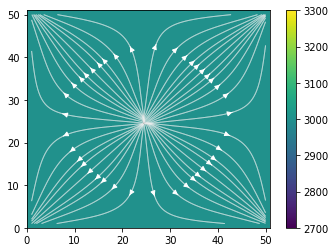

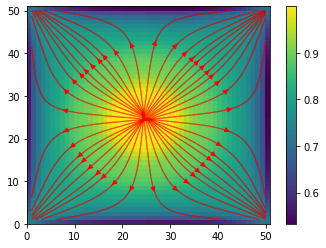

In [4]:
plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
m.plot_streamline(p,m.permx,'w')
plt.colorbar()

plt.figure(num=3, figsize=(12,4))
plt.subplot(122)
m.plot_streamline(p,z,'r')

plt.colorbar()

plt.show()

<img style="float: left;" src="slides/Slide9.JPG" width="80%">

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Apr 21 11:21:25 2020', '__version__': '1.0', '__globals__': [], 'R': array([[1.24103555, 1.29527888, 1.01853206, ..., 1.11042358, 1.21202895,
        1.36974811],
       [1.0864315 , 0.88446604, 1.04513145, ..., 1.07909692, 1.14160609,
        1.17616491],
       [1.0273755 , 1.0881972 , 1.09544405, ..., 1.00358957, 1.09812984,
        1.16501708],
       ...,
       [1.06027007, 1.17386961, 1.01889371, ..., 0.92451406, 0.97948104,
        1.15299854],
       [1.17715363, 1.1958351 , 1.09441376, ..., 1.02664944, 1.23237058,
        1.26909923],
       [1.20575497, 1.17968194, 1.0969242 , ..., 1.07098321, 1.1462919 ,
        1.25617421]]), 'i': array([[51]], dtype=uint8), 'iter': array([[1]], dtype=uint8), 'j': array([[51]], dtype=uint8), 'param': array([[10. , 20. ,  0. ,  1. ,  0.1]]), 'r': array([[1]], dtype=uint8), 'real': array([[1.2400587 ],
       [1.53385381],
       [0.03492554],
       ...,
       [1.06927

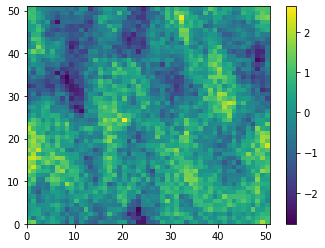

In [5]:
from scipy.io import loadmat
import numpy as np
data= loadmat('model_1.mat')
print(data)
realiz= np.array(data['realz'])
nb = m.nx * m.ny

p= realiz[0:2*nb:2]
plt.figure(num=4, figsize=(12,4))
plt.subplot(121)
plt.pcolor(realiz)
#plt.pcolor(p.reshape(m.ny, m.nx))
plt.colorbar()

plt.show()

<img style="float: left;" src="slides/Slide10.JPG" width="80%">

[[ 1.2400587   1.53385381  0.03492554 ...  1.08295191  1.93719733
   1.04348654]
 [ 0.40268548 -0.69120875  0.17899434 ...  0.70152453  0.88870352
   1.0333758 ]
 [ 0.08282374  0.41224891  0.45149965 ...  0.46604651  0.82832412
   0.72330284]
 ...
 [ 0.89405867  0.99524203  0.44591934 ...  1.1931271   1.39205843
   1.57101092]
 [ 1.04897047  0.90775258  0.45951648 ...  0.72690401  1.32205339
   1.03860975]
 [ 0.77347284  0.9448789  -0.04471624 ...  1.06927199  1.16129595
   1.10249869]]
51
[[ 1.2400587   1.53385381  0.03492554 ...  1.08295191  1.93719733
   1.04348654]
 [ 0.40268548 -0.69120875  0.17899434 ...  0.70152453  0.88870352
   1.0333758 ]
 [ 0.08282374  0.41224891  0.45149965 ...  0.46604651  0.82832412
   0.72330284]
 ...
 [ 0.89405867  0.99524203  0.44591934 ...  1.1931271   1.39205843
   1.57101092]
 [ 1.04897047  0.90775258  0.45951648 ...  0.72690401  1.32205339
   1.03860975]
 [ 0.77347284  0.9448789  -0.04471624 ...  1.06927199  1.16129595
   1.10249869]]
0.04
0.843047

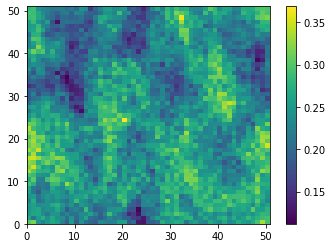

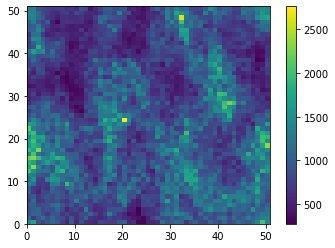

In [6]:
print(realiz)
print(len(realiz[:]))
r=realiz
#r=list(realiz.flatten())
print(r)
std= 0.04
print(std)
sigma= 0.24
S= np.std(r)
print(S)
M= np.mean(r)

phi=np.zeros(len(r))


phi= sigma-M*(std/S)+r*(std/S)
    #k[i]= 10e9*phi[i]
print(phi)
k= 100*np.exp(9*phi)
#phi=np.array([phi])
nb = m.nx * m.ny
p= phi[0:2*nb:2]
plt.figure(num=4, figsize=(12,4))
plt.subplot(121)
#plt.pcolor(phi)
plt.pcolor(phi)
plt.colorbar()

p= k[0:2*nb:2]
plt.figure(num=5, figsize=(12,4))
plt.subplot(121)
#plt.pcolor(phi)
plt.pcolor(k)
plt.colorbar()
plt.show()


<img style="float: left;" src="slides/Slide11.JPG" width="80%">

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Simulation ended


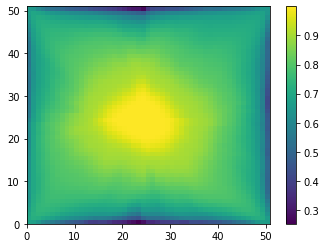

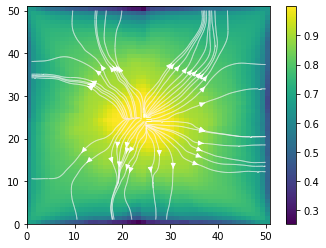

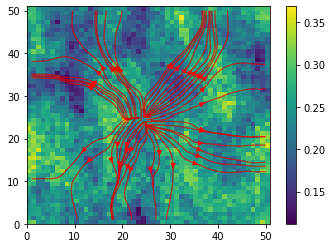

In [7]:
n= Model(k)
n.init()
n.run(2000)
print('Simulation ended')

X = np.array(n.physics.engine.X, copy=False)
nb = n.nx * n.ny

p= X[1:2*nb:2]
z= X[1:2*nb:2]

plt.figure(num=3, figsize=(12,4))
plt.subplot(121)
plt.pcolor(z.reshape(n.ny, n.nx))
plt.colorbar()
plt.show()

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
n.plot_streamline(p,z,'w')
plt.colorbar()
plt.show()

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
n.plot_streamline(p,phi,'r')
plt.colorbar()
plt.show()

<img style="float: left;" src="slides/Slide12.JPG" width="80%">

 1: Change the model to own generated permeability; keep the same physical distance between wells as the last practical
darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Total elapsed 0.091460 sec
	initialization 0.004510 sec
		connection list generation 0.001468 sec
	newton update 0.000000 sec
	simulation 0.082820 sec
		jacobian assembly 0.034990 sec
			interpolation 0.033586 sec
				acc flux interpolation 0.035943 sec
					body generation 0.034060 sec
						point generation 0.033410 sec
				rate interpolation 0.000000 sec
					body generation 0.000000 sec
						point generation 0.001212 sec
		linear solver setup 0.025488 sec
			GMRES 0.025466 sec
				CPR 0.025444 sec
					AMG 0.023873 sec
					ILU(0) 0.000844 sec
		linear solver solve 0.019778 sec
			GMRES 0.019749 sec
				CPR 0.016340 sec
					AMG 0.011315 sec
					ILU(0) 0.002809 sec
				SPMV_bsr 0.002893 sec
				prec_comm 0.000000 sec
		newton upda

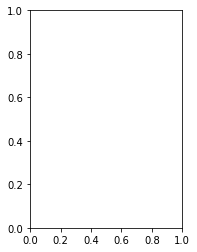

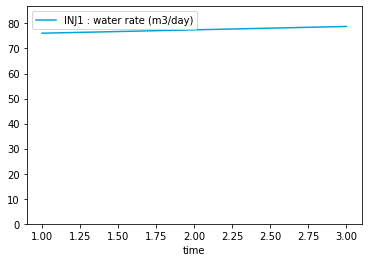

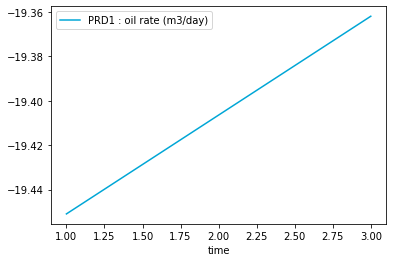

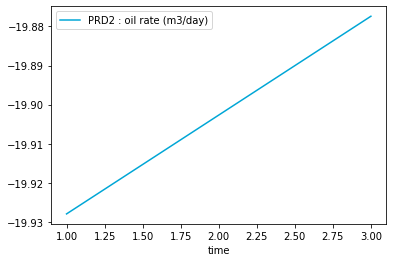

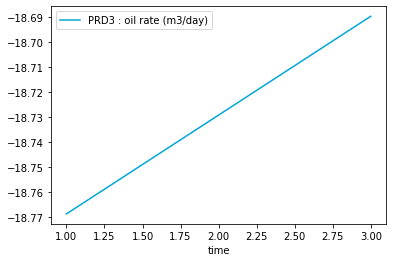

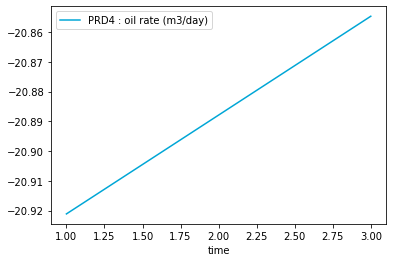

No handles with labels found to put in legend.


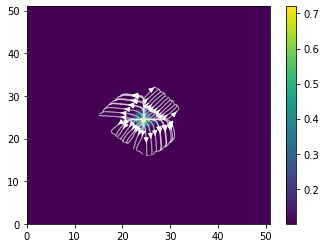

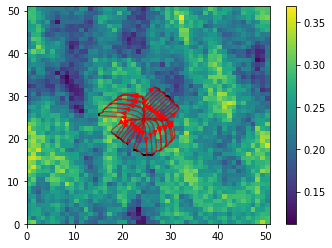

In [8]:
print(" 1: Change the model to own generated permeability; keep the same physical distance between wells as the last practical")


s= Model(k)
s.init()
s.run(3)
s.print_timers()
print('Simulation ended')

%matplotlib inline
import pandas as pd
time_data = pd.DataFrame.from_dict(s.physics.engine.time_data)
# wirte timedata to output file
time_data.to_pickle("darts_time_data.pkl")
# write timedata to excel file
writer = pd.ExcelWriter('time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()
# read data from output file
td = pd.read_pickle("darts_time_data.pkl")
# plot production rates
from darts.tools.plot_darts import *
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
PRO=['PRD1','PRD2','PRD3','PRD4']
P=np.zeros((len(PRO),len(time_data)))
plot_water_rate_darts('INJ1',time_data)
for i in range(len(PRO)):
    plot_oil_rate_darts(PRO[i],time_data)

plt.show()

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Scale (Bananas)')
ax1.set_title('first data set')
ax1.legend()


X = np.array(s.physics.engine.X, copy=False)
nb = s.nx * s.ny

p= X[1:2*nb:2]
z= X[1:2*nb:2]

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
s.plot_streamline(p,z,'w')
plt.savefig('testplot3.png')


plt.colorbar()
plt.show()

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
s.plot_streamline(p,phi,'r')
plt.savefig('testplot4.png')

plt.colorbar()
plt.show()


<h1>Results</h1>

- Comparing both cases (A= $10000$ days of producing) & (B= $3$ days of producing) one can see that breakthrough of oil has been reached for case A and therfore around $1000$ days breakthrough has been reached for the producer wells and no oil is produced anymore.  
- Streamline profile case A shows that there is only communicating of flow between the injector at the middle and one or two producers. For case B time is to short to trace the streamlines from injector towards the producers in the corners therfore only partly the streamlines will be visible, see streamplot.JPG vs streamplot3.JPG. 
- From the oil rate plots it shows a drop in producing of oil after 1000 days for case B compared to case A where the producers equally produce the same amount of oil through time. 



In [9]:
print('4= change position of injector well and locate producer well along position of slong hotizontal lines through injector')



4= change position of injector well and locate producer well along position of slong hotizontal lines through injector


In [10]:
class Model(DartsModel):
    def __init__(self, perm=None, nd = 51, db = 8):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.ix = np.int32((1/3)*self.nx)
        self.iy = np.int32((2/3)*self.ny)
        
        self.x = np.int32((1/3)*self.nx )
        self.y = np.int32(self.ny)
        
        self.xx = np.int32((1/3)*self.nx)
        self.yy = np.int32(self.ny /self.ny )
        
        self.xxx = np.int32(self.nx /self.nx)
        self.yyy = np.int32((2/3)*self.ny)
        
        self.xxxx = np.int32(self.nx)
        self.yyyy = np.int32((2/3)*self.ny)
        
        
        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=10)

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.x, self.y, 1, well_index=10)
        
        self.reservoir.add_well("PRD2")
        self.reservoir.add_perforation(self.reservoir.wells[-1],self.xx ,self.yy, 1, well_index=10)
        
        self.reservoir.add_well("PRD3")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.xxx, self.yyy, 1, well_index=10)
        
        self.reservoir.add_well("PRD4")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.xxxx, self.yyyy, 1, well_index=10)
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Total elapsed 0.632962 sec
	initialization 0.003561 sec
		connection list generation 0.001129 sec
	newton update 0.000000 sec
	simulation 0.625449 sec
		jacobian assembly 0.330063 sec
			interpolation 0.321885 sec
				acc flux interpolation 0.324109 sec
					body generation 0.312121 sec
						point generation 0.305863 sec
				rate interpolation 0.000000 sec
					body generation 0.000000 sec
						point generation 0.011748 sec
		linear solver setup 0.141717 sec
			GMRES 0.141561 sec
				CPR 0.141424 sec
					AMG 0.133220 sec
					ILU(0) 0.004502 sec
		linear solver solve 0.135672 sec
			GMRES 0.135442 sec
				CPR 0.110032 sec
					AMG 0.075784 sec
					ILU(0) 0.019120 sec
				SPMV_bsr 0.019729 sec
				prec_comm 0.000000 sec
		newton update 0.002106 sec
			composition correction 0.000700 sec

Simulation ended


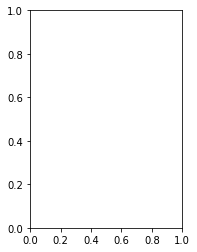

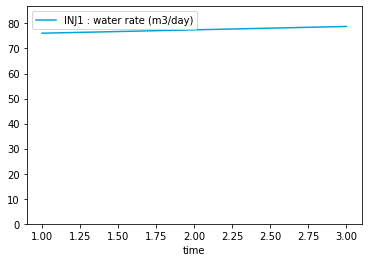

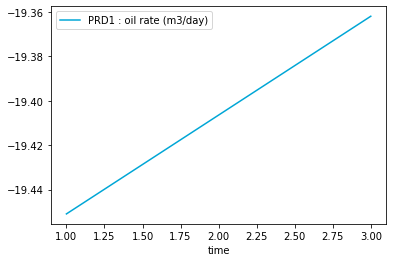

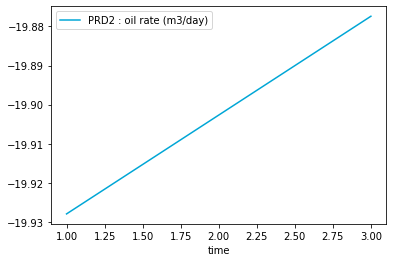

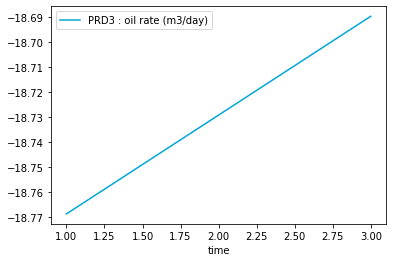

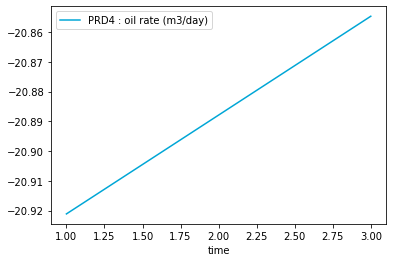

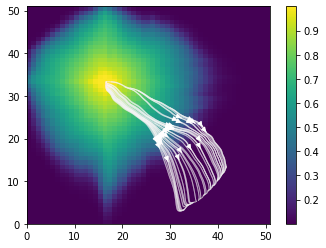

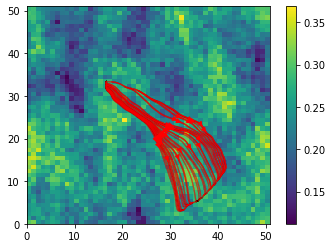

In [11]:
f= Model(k)
f.init()
f.run(400)
f.print_timers()
print('Simulation ended')

%matplotlib inline
import pandas as pd
time_data = pd.DataFrame.from_dict(s.physics.engine.time_data)
# wirte timedata to output file
time_data.to_pickle("darts_time_data.pkl")
# write timedata to excel file
writer = pd.ExcelWriter('time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()
# read data from output file
td = pd.read_pickle("darts_time_data.pkl")
# plot production rates
from darts.tools.plot_darts import *
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
PRO=['PRD1','PRD2','PRD3','PRD4']
P=np.zeros((len(PRO),len(time_data)))
plot_water_rate_darts('INJ1',time_data)
for i in range(len(PRO)):
    plot_oil_rate_darts(PRO[i],time_data)

plt.show()



X = np.array(f.physics.engine.X, copy=False)
nb = f.nx * f.ny

p= X[1:2*nb:2]
z= X[1:2*nb:2]

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
f.plot_streamline(p,z,'w')
plt.savefig('testplot5.png')


plt.colorbar()
plt.show()

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
f.plot_streamline(p,phi,'r')
plt.savefig('testplot6.png')

plt.colorbar()
plt.show()


<h1>Results</h1> 

- From the above plots it can be observed that the flow divergence between the producer wells $(nx=nx and ny= (2/3)*ny)$ and $(nx= (1/3)*nx and ny= ny/ny)$. This has to due flow paths develop through the higher peremabele regions and therfore preferenble stream along theses channels from injector towards producers. 

In [12]:
print('5= with appropiate well management balance the production in this system so breakthrough happens simulataneaulsy')



5= with appropiate well management balance the production in this system so breakthrough happens simulataneaulsy


<h1>Method</h1>  

- To balance the production the well index for each well needs to be adjusted in order to flow through the non peremable regions and balance thereby the production an higher well index means the well is producer at higher flow rate and therfore breakthrough will be happend simulataneauly for the well configuration. 
- By increasing the injector flow rate (higher well index) the oil will earlier breakthrough and therfore breakthrough of the producers wells happens simultaneausly. 



In [24]:
class Model(DartsModel):
    def __init__(self, perm=None, nd = 51, db = 8):
        # call base class constructor
        super().__init__()

        # measure time spend on reading/initialization
        self.timer.node["initialization"].start()

        # create reservoir
        self.nx = nd
        self.ny = nd
        self.nz = 1
        
        self.dx = db
        self.dy = db
        self.dz = 4

        if (perm is None):
            perm = np.ones(self.nx*self.ny)*3000
        else:
            perm = perm.reshape(self.nx*self.ny)
            
        self.permx = perm
        self.permy = perm
        self.permz = 0.1 * perm
        self.poro = 0.2
        self.depth = 4000

        # run discretization
        self.reservoir = StructReservoir(self.timer, nx=self.nx, ny=self.ny, nz=self.nz, dx=self.dx, dy=self.dy,
                                         dz=self.dz, permx=self.permx, permy=self.permy, permz=self.permz,
                                         poro=self.poro, depth=self.depth)

        self.ix = np.int32((1/3)*self.nx)
        self.iy = np.int32((2/3)*self.ny)
        
        self.x = np.int32((1/3)*self.nx )
        self.y = np.int32(self.ny)
        
        self.xx = np.int32((1/3)*self.nx)
        self.yy = np.int32(self.ny /self.ny )
        
        self.xxx = np.int32(self.nx /self.nx)
        self.yyy = np.int32((2/3)*self.ny)
        
        self.xxxx = np.int32(self.nx)
        self.yyyy = np.int32((2/3)*self.ny)
        
        
        
        self.reservoir.add_well("INJ1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.ix, self.iy, 1,  well_index=110)

        self.reservoir.add_well("PRD1")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.x, self.y, 1, well_index=70)
        
        self.reservoir.add_well("PRD2")
        self.reservoir.add_perforation(self.reservoir.wells[-1],self.xx ,self.yy, 1, well_index=60)
        
        self.reservoir.add_well("PRD3")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.xxx, self.yyy, 1, well_index=70)
        
        self.reservoir.add_well("PRD4")
        self.reservoir.add_perforation(self.reservoir.wells[-1], self.xxxx, self.yyyy, 1, well_index=60)
        
        # create physics
        self.physics = DeadOil(timer=self.timer, physics_filename='physics.in',
                               n_points=401, min_p=300, max_p=600, min_z=1e-8)

        self.params.first_ts = 1
        self.params.mult_ts = 2
        self.params.max_ts = 50
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-3

        self.inj = [1]

        self.runtime = 1000

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=400,
                                                    uniform_composition=[0.1])

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if w.name[:3] == "INJ":
                w.control = self.physics.new_bhp_water_inj(410, self.inj)
                # w.constraint = self.physics.new_rate_water_prod(210)
            else:
                w.control = self.physics.new_bhp_prod(390)

    # This function plots streamlines based on passed pressure solution 
    # and permebility map from model class
    def plot_streamline(self, p, array, col='r'):

        P_2D = p.reshape(self.nx, self.ny)
        kx = self.permx.reshape(self.ny, self.nx)
        ky = self.permy.reshape(self.ny, self.nx)
        nvx, nvy = (self.nx-1, self.ny-1)

        v = np.zeros((nvx, nvy))
        u = np.zeros((nvx, nvy))
        ir, jr = (range(nvx), range(nvy))

        for i in ir:
            v[i, jr] = (kx[i, jr] + kx[i + 1, jr]) * (P_2D[i, jr] - P_2D[i + 1, jr])
        for j in jr:
            u[ir, j] = (ky[ir, j] + ky[ir, j + 1]) * (P_2D[ir, j] - P_2D[ir, j + 1])

        # find circle in 2D index array with radius r
        x = np.arange(0, nvx)
        y = np.arange(0, nvy)
        arr = np.zeros((nvx,nvy))
        r = 6. # make sure that the model is larger than [2r] * [2r]
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < r ** 2] = 1
        arr[(x[np.newaxis, :] - self.ix) ** 2 + (y[:, np.newaxis] - self.iy) ** 2 < (r-1) ** 2] = 0

        # starting points for streamlines
        sp = np.array(np.where(arr == 1))
        y, x = np.mgrid[1:nvy+1, 1:nvx+1]
        cont = plt.streamplot(x, y, u, v, density=100, color=col, linewidth=1, cmap='autumn', start_points=sp.T)

        array=array.reshape(self.ny, self.nx)
        plt.pcolor(array)

darts-package built on 08/10/2020 18:32:54 by root@runner-Gd7HMPkj-project-1205-concurrent-0 from 180bd2c
Building connection list...
Total elapsed 1.952061 sec
	initialization 0.003882 sec
		connection list generation 0.001336 sec
	newton update 0.000000 sec
	simulation 1.941719 sec
		jacobian assembly 1.120867 sec
			interpolation 1.098902 sec
				acc flux interpolation 1.100608 sec
					body generation 1.055925 sec
						point generation 1.029719 sec
				rate interpolation 0.000000 sec
					body generation 0.000000 sec
						point generation 0.066243 sec
		linear solver setup 0.327663 sec
			GMRES 0.327212 sec
				CPR 0.326760 sec
					AMG 0.307867 sec
					ILU(0) 0.010617 sec
		linear solver solve 0.409285 sec
			GMRES 0.408852 sec
				CPR 0.331455 sec
					AMG 0.229158 sec
					ILU(0) 0.058575 sec
				SPMV_bsr 0.057384 sec
				prec_comm 0.000000 sec
		newton update 0.005199 sec
			composition correction 0.001722 sec

Simulation ended


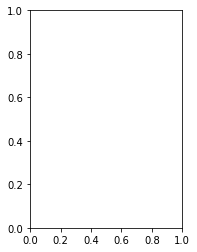

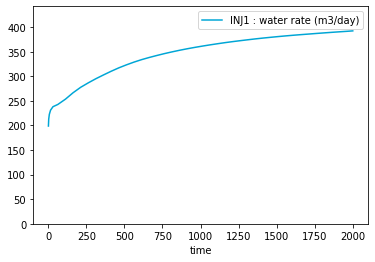

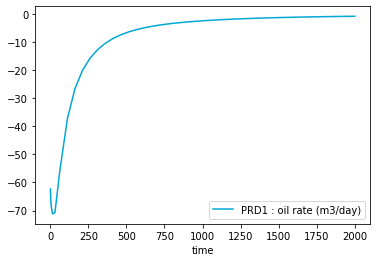

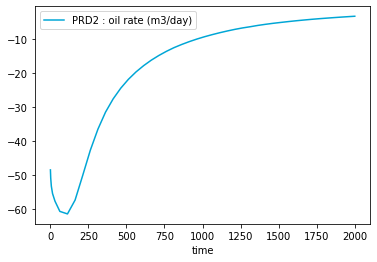

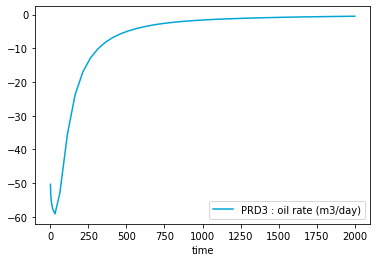

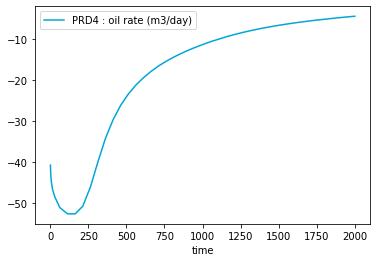

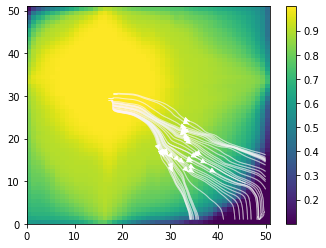

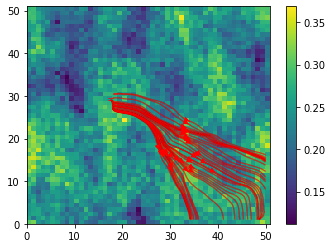

In [25]:
g= Model(k)
g.init()
g.run(2000)
g.print_timers()
print('Simulation ended')

%matplotlib inline
import pandas as pd
time_data = pd.DataFrame.from_dict(g.physics.engine.time_data)
# wirte timedata to output file
time_data.to_pickle("darts_time_data.pkl")
# write timedata to excel file
writer = pd.ExcelWriter('time_data.xlsx')
time_data.to_excel(writer, 'Sheet1')
writer.save()
# read data from output file
td = pd.read_pickle("darts_time_data.pkl")
# plot production rates
from darts.tools.plot_darts import *
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
PRO=['PRD1','PRD2','PRD3','PRD4']
P=np.zeros((len(PRO),len(time_data)))
plot_water_rate_darts('INJ1',time_data)
for i in range(len(PRO)):
    plot_oil_rate_darts(PRO[i],time_data)

plt.show()



X = np.array(g.physics.engine.X, copy=False)
nb = g.nx * g.ny

p= X[1:2*nb:2]
z= X[1:2*nb:2]

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
g.plot_streamline(p,z,'w')
plt.savefig('testplot5.png')


plt.colorbar()
plt.show()

plt.figure(num=2, figsize=(12,4))
plt.subplot(121)
g.plot_streamline(p,phi,'r')
plt.savefig('testplot6.png')

plt.colorbar()
plt.show()


<h1>Results</h1>  

- From the above stream plots it can be seen that breakthrough happens (streamlines end in producer) bij increasing the well index of the injector the oil rates approximatedly breakthrough on the same moment in time, see above oil rate curves for the four producers. 
